In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp


In [3]:
file = '../data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


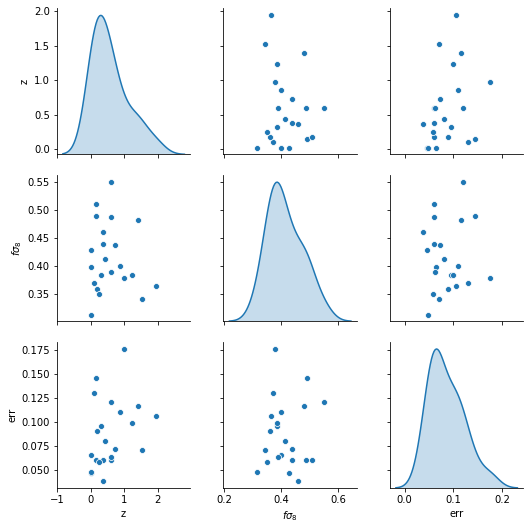

In [4]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("Distfs8.png")

In [5]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
# a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
even = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[shuffle]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])

Read the data for cosmic chronometers

In [6]:
z = data[:,0]
y = data[:,1:]
# print(randomize)
np.max(z)

1.944

In [7]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [8]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [9]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()

In [10]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [11]:
# batch_size = 4
batch_size = 1
input_z = Input(shape = (1,))
epochs = 100

In [12]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0592 - val_loss: 0.0247
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0182 - val_loss: 0.0134
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0100
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0129 - val_loss: 0.0100
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0040
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 10/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 11

Epoch 83/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 84/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 85/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 86/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 87/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 88/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 89/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 90/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 91/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 92/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0027


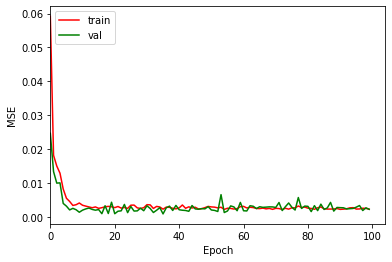

In [13]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_fs8.png", dpi=200)
# plt.savefig("loss_epochs_fs8_1000.png", dpi=200)


In [14]:
# neural_model.save("FFNN_fs8.h5")

In [15]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 0.0009567601955495775 0.0024885754100978374 mil epochs
# 0.0010785672347992659 0.0010806184727698565 500 epochs
# 0.0020020001102238894 0.0008378626080229878 100e
# 0.0021847975440323353 0.0009035465191118419 50e
# 0.002703879727050662 0.0013360671000555158 20e
### 100
# 0.001952524995431304 0.0008627769420854747
# 0.001952524995431304 0.002966993721202016
dif_loss = model_train.history['val_loss'][-1] - model_train.history['val_loss'][-2]
val_loss = model_train.history['val_loss'][-1]
dif_loss, val_loss

0.002178030088543892 0.0008687762310728431
0.002278797561302781 0.0022176778875291348


(-0.0004466520622372627, 0.0022176778875291348)

In [16]:
pred = neural_model.predict(z_test)
pred

array([[0.453082  , 0.0630717 ],
       [0.46972072, 0.09941782],
       [0.46132872, 0.10732387],
       [0.44684494, 0.11351064],
       [0.40101692, 0.12198105]], dtype=float32)

In [17]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [18]:
ranz = np.random.uniform(0, 2, size=1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


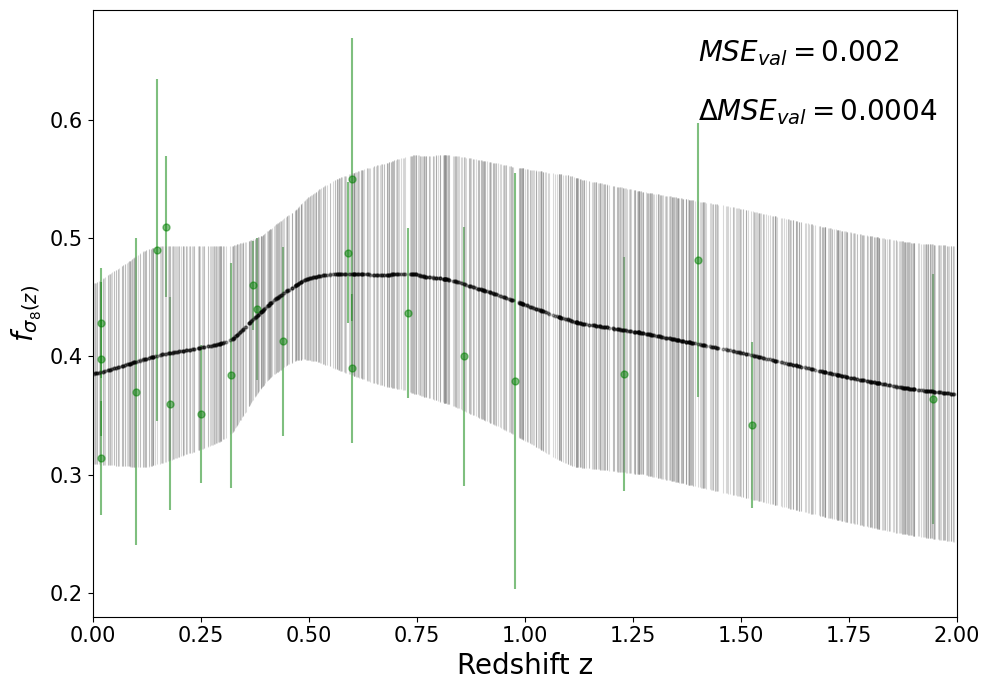

In [43]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.3, c='k',)
plt.ylabel("$f_{\sigma_8(z)}$", fontsize=20)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.text( 1.4, 0.65, "$MSE_{val} = 0.002$", fontsize=20 )
plt.text( 1.4, 0.6, "$\Delta MSE_{val} = 0.0004$", fontsize=20 )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.legend(loc='upper right')
# plt.legend()
plt.savefig("synthetic_fs8_100.png")

In [20]:
from functools import partial
# Cosmological constants
Om = 0.27
# variance network
s8 = 0.8
w0 = -1

In [21]:
def Ezlcdm(a):
    return np.sqrt(Om*(1/a)**3 + 1 - Om)

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

  
def growth_lcdm(z):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_lcdm, 1e-7, af)
    gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr
    

def growth_owacdm(z, w0, wa):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_owacdm, 1e-7, af, args=(w0, wa))
    gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr

# returns the growth factor as a function of redshift
def GrowthIntegrand_a_lcdm(a):
    rhsquareda = RHSquared_a_lcdm(a) 
    return 1./(rhsquareda*a*a)**(1.5)

def GrowthIntegrand_a_owacdm(a, w0, wa):
    rhsquareda = RHSquared_a_owacdm(a, w0=w0, wa=wa) 
    return 1./(rhsquareda*a*a)**(1.5)


def fs8lcdm(z):
    return -s8*(1+z)*derivative(growth_lcdm, z, dx=1e-6)/growth_lcdm(0)

def fs8owacdm(z, w0=-1, wa=0):
    return -s8*(1+z)*derivative(growth_owacdm, z, dx=1e-6, args=(w0, wa))/growth_owacdm(0, w0, wa)


# def Hlcdm(a, H0=73.24):
#     z = 1./a-1
#     return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

In [22]:
z = np.linspace(0.0, 2, 100)
flcdm = []
fowacdm1 = []
fowacdm2 = []
fowacdm3 = []

# flcdm = []
for zz in z:
    flcdm.append(fs8lcdm(zz))
    fowacdm1.append(fs8owacdm(zz, w0=-1, wa=0.5))
    fowacdm2.append(fs8owacdm(zz, w0=-1, wa=-0.5))
    fowacdm3.append(fs8owacdm(zz, w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
fowacdm2 = np.array(fowacdm2)
fowacdm3 = np.array(fowacdm3)


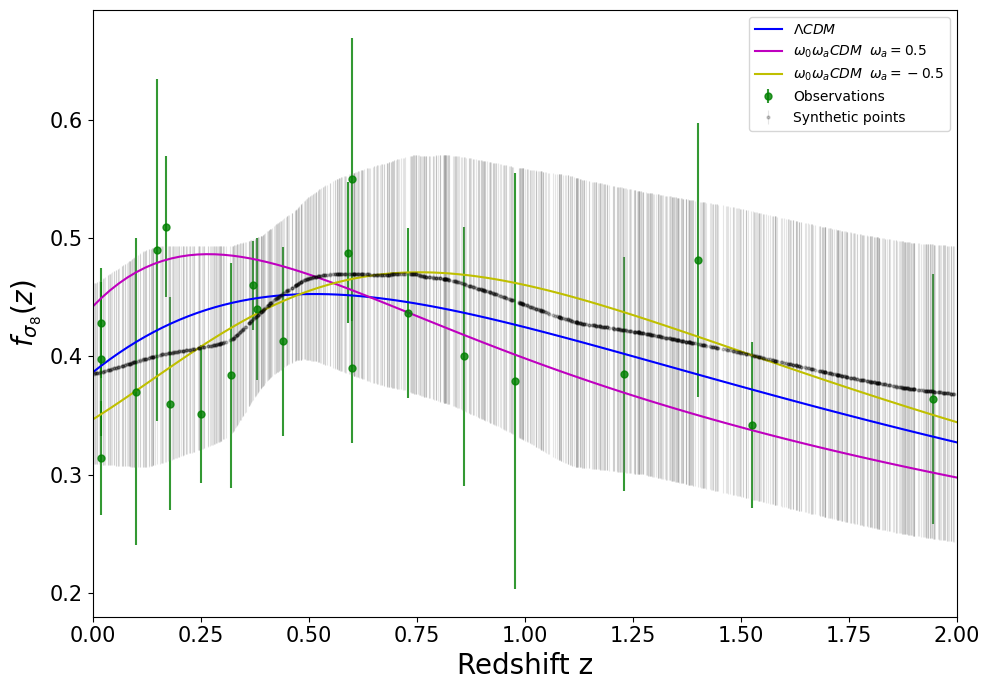

In [46]:
z = np.linspace(0, 2, 100)
plt.figure(figsize=(10, 7), dpi=100)

plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.2, c='k',)

plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_a=0$', c='brown')
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("$f_{\sigma_8}(z)$", fontsize=20)
plt.tight_layout()
plt.legend()

plt.savefig("Syntheticfs8.png",dpi=80)

In [24]:
# pred_random.shape, r.shape

In [25]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [26]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)

# np.savetxt("annfs850_.dat",mookHz, delimiter=" ")

In [27]:
mookHz

array([[1.436843  , 0.40801516, 0.12126796],
       [0.47151946, 0.46063697, 0.06379451],
       [0.45284469, 0.45641261, 0.06312428],
       [1.03851101, 0.43883887, 0.11784498],
       [0.0398411 , 0.38892946, 0.08094184],
       [0.95055112, 0.45045972, 0.11194934],
       [1.87549545, 0.37363973, 0.12375517],
       [1.07842238, 0.43362042, 0.12080674],
       [0.59973288, 0.46959779, 0.08549203],
       [1.83328721, 0.37640437, 0.12347448],
       [1.38086119, 0.41204137, 0.12071581],
       [0.39963273, 0.44113252, 0.06346948],
       [1.436843  , 0.40801516, 0.12126796],
       [1.27151534, 0.4198688 , 0.11970508],
       [0.66487069, 0.46926209, 0.09315547],
       [0.30806521, 0.41233304, 0.08118641],
       [1.30736291, 0.41732737, 0.11999092],
       [1.92771642, 0.37102279, 0.12426357],
       [1.91255475, 0.37166658, 0.12406556],
       [0.62374029, 0.46954629, 0.08838619],
       [1.21707728, 0.42302433, 0.1205695 ],
       [0.27442756, 0.40916181, 0.08432438],
       [0.

In [28]:
predy_reduced[:,1]

array([0.12126796, 0.06379451, 0.06312428, 0.11784498, 0.08094184,
       0.11194934, 0.12375517, 0.12080674, 0.08549203, 0.12347448,
       0.12071581, 0.06346948, 0.12126796, 0.11970508, 0.09315547,
       0.08118641, 0.11999092, 0.12426357, 0.12406556, 0.08838619,
       0.1205695 , 0.08432438, 0.08124174, 0.12307185, 0.12009773,
       0.07620721, 0.06578721, 0.09738606, 0.11970508, 0.12151426,
       0.08596194, 0.0688127 , 0.11158554, 0.06374539, 0.12102912,
       0.09129582, 0.06308313, 0.09213489, 0.11450624, 0.10263885,
       0.11194934, 0.06333086, 0.12184657, 0.12377095, 0.12176505,
       0.12075874, 0.10364057, 0.12231451, 0.10507762, 0.08640532],
      dtype=float32)

In [29]:
error  = predy_reduced[:,1]**2
error

array([0.01470592, 0.00406974, 0.00398468, 0.01388744, 0.00655158,
       0.01253265, 0.01531534, 0.01459427, 0.00730889, 0.01524595,
       0.01457231, 0.00402838, 0.01470592, 0.01432931, 0.00867794,
       0.00659123, 0.01439782, 0.01544143, 0.01539226, 0.00781212,
       0.014537  , 0.0071106 , 0.00660022, 0.01514668, 0.01442346,
       0.00580754, 0.00432796, 0.00948405, 0.01432931, 0.01476572,
       0.00738945, 0.00473519, 0.01245133, 0.00406348, 0.01464805,
       0.00833493, 0.00397948, 0.00848884, 0.01311168, 0.01053473,
       0.01253265, 0.0040108 , 0.01484659, 0.01531925, 0.01482673,
       0.01458267, 0.01074137, 0.01496084, 0.01104131, 0.00746588],
      dtype=float32)

In [30]:
diagcov = np.diag(error) #inverso
# np.savetxt("annfs8_cov50_.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(50, 50)

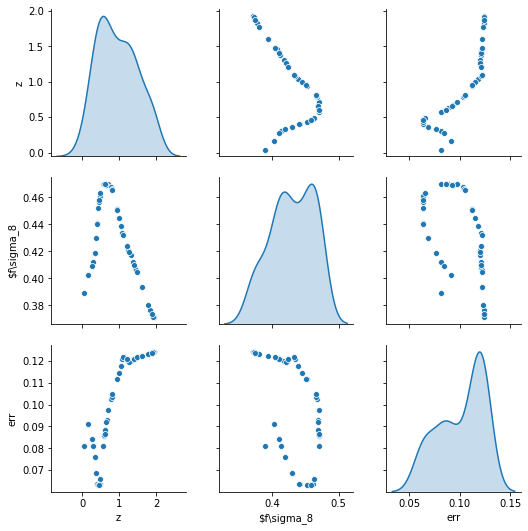

In [31]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("dist50fs8fake_.png")

In [32]:
from astroNN.nn.layers import MCDropout

In [33]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((80,), (22, 1), (20,), (0, 1))

In [34]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model2 = model_regression_dropout(num_hidden=[100, 50, 50])
model2.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model2.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/2000
5/5 [==============================] - 0s 25ms/step - loss: 0.0883 - val_loss: 0.0730
Epoch 2/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0753 - val_loss: 0.0686
Epoch 3/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0757 - val_loss: 0.0612
Epoch 4/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0735 - val_loss: 0.0657
Epoch 5/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0685 - val_loss: 0.0535
Epoch 6/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0687 - val_loss: 0.0535
Epoch 7/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0655 - val_loss: 0.0525
Epoch 8/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0701 - val_loss: 0.0574
Epoch 9/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0628 - val_loss: 0.0513
Epoch 10/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0574 - val_loss: 0.0430
Epoch 11/2000
5/5 

Epoch 84/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.0111
Epoch 85/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0099
Epoch 86/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0045
Epoch 87/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0111
Epoch 88/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0147
Epoch 89/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 90/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.0062
Epoch 91/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0130 - val_loss: 0.0037
Epoch 92/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.0092
Epoch 93/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0097
Epoch 94/2

5/5 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 167/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 168/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 169/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0050
Epoch 170/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 171/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0054
Epoch 172/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0094
Epoch 173/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0042
Epoch 174/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0065
Epoch 175/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 176/2000


5/5 [==============================] - 0s 5ms/step - loss: 0.0078 - val_loss: 0.0036
Epoch 249/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 250/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 251/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 252/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0067
Epoch 253/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 254/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 255/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0075
Epoch 256/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 257/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 258/2000


5/5 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 331/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 332/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 333/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 334/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 335/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 336/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0020
Epoch 337/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 338/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 339/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 340/2000


Epoch 412/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 413/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0092
Epoch 414/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 415/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 416/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 417/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 418/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 419/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 420/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 421/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0032


Epoch 494/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 495/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 496/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 497/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 498/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 499/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 500/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 501/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 502/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0089
Epoch 503/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0049


Epoch 576/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 577/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 578/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 579/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 580/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 581/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 582/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 583/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0054
Epoch 584/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 585/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0020


Epoch 658/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0082
Epoch 659/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 660/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 661/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 662/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 663/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 664/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 665/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 666/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 667/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0017


Epoch 740/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 741/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 742/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 743/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 744/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 745/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 746/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 747/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 748/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 749/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0013


Epoch 822/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0056
Epoch 823/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 824/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 825/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 826/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 827/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 828/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 829/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 830/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 831/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0044


Epoch 904/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 905/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 906/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 907/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 908/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 909/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 910/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 911/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 912/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 913/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0024


Epoch 986/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 987/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 988/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 989/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 990/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 991/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 992/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 993/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 994/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 995/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0026


5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0055
Epoch 1068/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 1069/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 1070/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 1071/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 1072/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 1073/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 1074/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 1075/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0054
Epoch 1076/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 1149/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 1150/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 1151/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 1152/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 1153/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 1154/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1155/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 1156/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 1157/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 1230/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 1231/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 1232/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 1233/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 1234/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 1235/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 1236/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 7.3062e-04
Epoch 1237/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 1238/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0014
Ep

5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 1311/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 1312/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 1313/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 1314/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 1315/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 1316/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 1317/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 1318/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 1319/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 1392/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 1393/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 1394/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 1395/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 1396/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 1397/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 1398/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 1399/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 1400/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 1473/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 1474/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 1475/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 1476/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1477/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 1478/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 1479/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1480/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 1481/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 1554/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1555/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 1556/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 1557/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 1558/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 1559/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 1560/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1561/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 1562/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 1635/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 1636/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 1637/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 1638/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 1639/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1640/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 1641/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 1642/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 1643/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1716/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 1717/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 1718/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 1719/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 1720/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 1721/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 1722/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 1723/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 1724/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 1797/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 1798/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 1799/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 1800/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 1801/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 1802/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 1803/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 1804/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1805/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 1878/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 1879/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 1880/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 1881/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 1882/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 1883/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 1884/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 1885/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 1886/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 1959/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 1960/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 1961/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 1962/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 1963/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 1964/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1965/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 1966/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 1967/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 

In [35]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [36]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.030332711879123876, 0.016294644265617338)

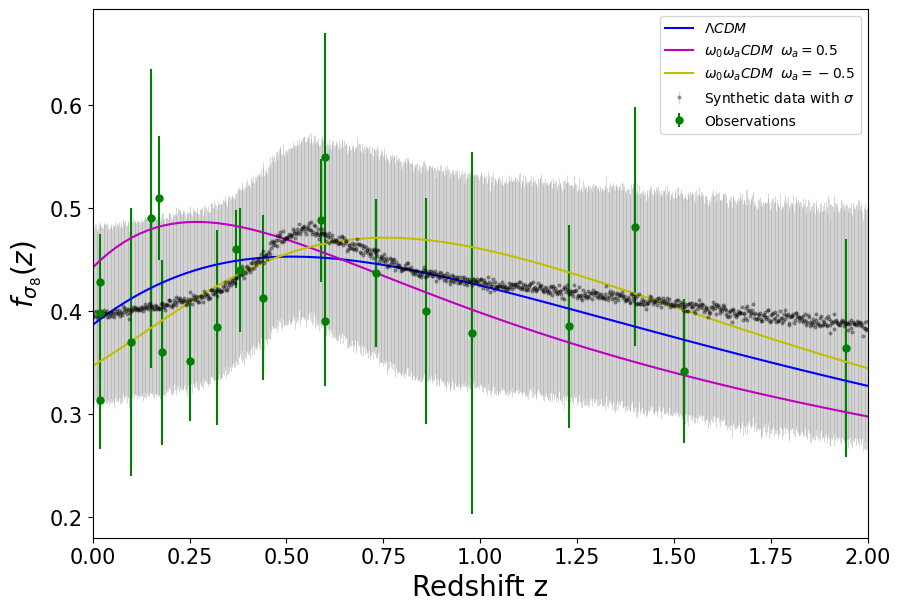

In [48]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.3, c='k',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0,2)
plt.ylabel('$f_{\sigma_8}(z)$', fontsize=20)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('fs8_dropout.png', dpi=80)

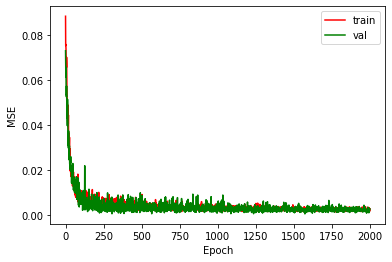

In [38]:
plt.plot(model2_train.history['loss'], color='r')
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.legend(['train', 'val'], loc='upper right')
# plt.savefig('lossfs8dropout.png', dpi=100)

In [39]:
# model2.save("FFNN+MC-DO_fs8.h5")

In [40]:
mookdpfs8 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("annfs850dropout.dat",mookdpfs8, delimiter=" ")

In [41]:
diagcov2 = np.diag(sigma**2) #inverso
# np.savetxt("annfs8_cov50dropout.dat", diagcov2, delimiter= " ", header="#50 50")

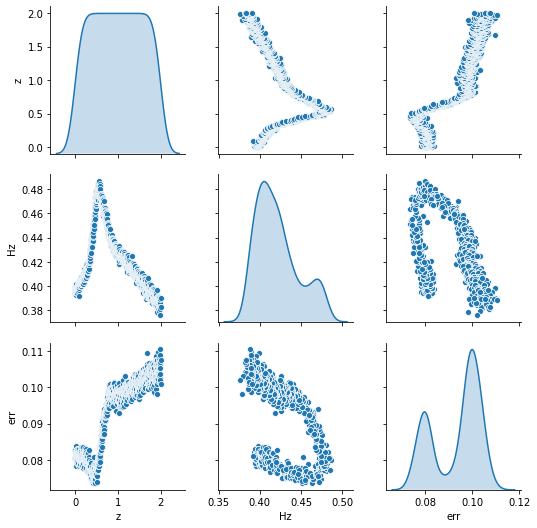

In [42]:
dfMook = pd.DataFrame(mookdpfs8, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50fs8dmookdropout.png")